# Lecture 4: 3D Audio and Spatial Sound!

We'll explore how to create immersive audio experiences that simulate the perception of sound in three-dimensional space.


### Imports and helpers

In [4]:
import numpy as np
from scipy.signal import convolve
from matplotlib import pyplot as plt
from scipy.io.wavfile import read, write
from scipy import fft
import os

def wavread(path):
    sr, s = read(path)
    return sr, s.astype( 'float32')/32768

def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display( HTML( 
    '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
    '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
    ))

## 1. Static sources in 3D space using ITD and ILD

Let's try to understand how ITD and ILD can be used to simulate the perception of sound in 3D space.

### Interaural Time Difference (ITD)
This is the difference in arrival time of a sound between our two ears. Using the pythagorean theorem, we can calculate the time difference between the left and right ear for a given source location (time = distance / speed).

### Interaural Level Difference (ILD)
This is the difference in sound intensity between our two ears. When a sound comes from the left, it's louder in the left ear than the right ear. This is what we simulate using ILD. The attenuation factor is used to control the difference in intensity.

### Exercise
For our case, let's assume the source distance is 2 meters. We'll also set our attenuation factor to 0.7.

In [5]:
# constants
SOURCE_DIST = 2
EAR_RADIUS = 0.1
ATTENUATION = 0.7
SPEED_OF_SOUND = 343.3 

In [6]:
def itd(angle, sr):
    """Compute the interaural time difference (ITD) for a given angle and sample rate.

    Args:
        angle (float): angle, in degrees, that the source sound is relative to a two-meter distance from the listener's head
        sr (int): sample rate of the sound

    Returns:
        (int, int): value of the ITD for the left and right ears.
    """    
    angle = np.radians(angle)
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    
    left_distance = np.sqrt((2 * cos_angle)**2 + (SOURCE_DIST * sin_angle + EAR_RADIUS)**2)
    right_distance = np.sqrt((2 * cos_angle)**2 + (SOURCE_DIST * sin_angle - EAR_RADIUS)**2)
    
    left_itd = left_distance / SPEED_OF_SOUND * sr
    right_itd = right_distance / SPEED_OF_SOUND * sr
    
    return int(left_itd), int(right_itd)

def ild(angle, left_itd, right_itd):
    """Compute the interaural level difference (ILD) for a given angle and ITD values.

    Args:
        angle (float): angle, in degrees
        left_itd (int): the left ITD value
        right_itd (int): the right ITD value

    Returns:
        (float, float): ILD values for the left and right ears.
    """    
    angle = np.radians(angle)
    left_ild = 1.0
    right_ild = 1.0
    if right_itd > left_itd:
        left_ild = ATTENUATION * np.cos(angle)
    elif left_itd > right_itd:
        right_ild = ATTENUATION * np.cos(angle)
    return left_ild, right_ild

def apply_itd_ild(left_sample, right_sample, angle, sr):
    """Convolves the left and right samples with their respective ITD and ILD filters.

    Args:
        left_sample (np.ndarray): left sample array
        right_sample (np.ndarray): right sample array
        angle (float): angle to "move" the sound to, in degrees
        sr (int): sample rate of the left and right samples.

    Returns:
        np.ndarray: convolved sound array with the ITD and ILD filters applied.
    """
    left_itd, right_itd = itd(angle, sr)
    left_ild, right_ild = ild(angle, left_itd, right_itd)
    
    left_filter = np.zeros(max(left_itd, right_itd)*2)
    left_filter[right_itd] = left_ild
    left_sample = convolve(left_sample, left_filter)
    
    right_filter = np.zeros(max(left_itd, right_itd)*2)
    right_filter[left_itd] = right_ild
    right_sample = convolve(right_sample, right_filter)

    result = np.vstack((left_sample, right_sample))
    return result, left_filter, right_filter

## Wait, convolution?

Convolution is an operation performed on two functions, $f$ and $g$, to produce a third function $(f * g)$. In theory, this is performed by integrating against the product of $f$ and $g$, with one of the functions reflected on the y-axis and shifted over by some constant $\tau$. In reality, we're going to perform a *discrete convolution* by summing the products of $f[i]$ and $g[i]$, for $i$ in some range, in order to compute the convolution.

One other important fact: *convolution* in the *time domain* is equivalent to *multiplication* in the *frequency domain*! In other words, multiplying two fourier-transformed functions together is the same as taking the convolution of their original sounds. Hold onto this for the rest of the notebook.

For our purposes, it's enough to call `scipy.signal.convolve` and let Scipy do the heavy lifting :)

Anyway, let's try this for the following source locations
- Straight ahead

- 45 degrees to the left

- 80 degrees to the right

- 160 degrees to the left

In [36]:
sr, sample = wavread('./data/crumble.wav')
sound(sample, sr, label="original sample")

angles = [0, 45, 80, 160, 270, 360]
labels = [f'{i} degrees' for i in angles]

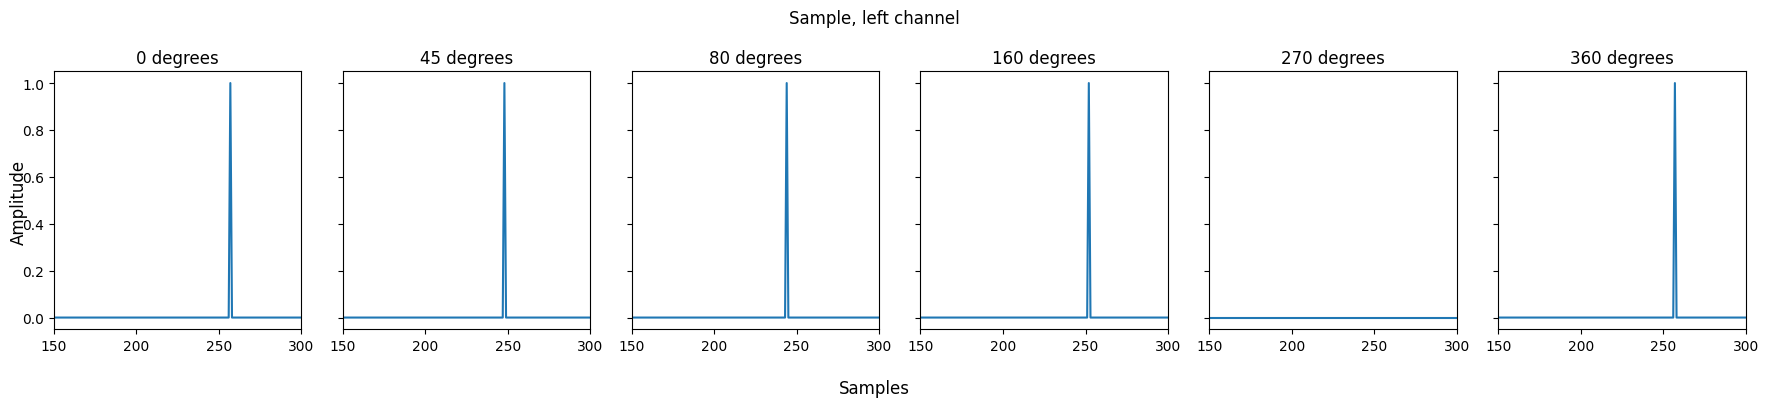

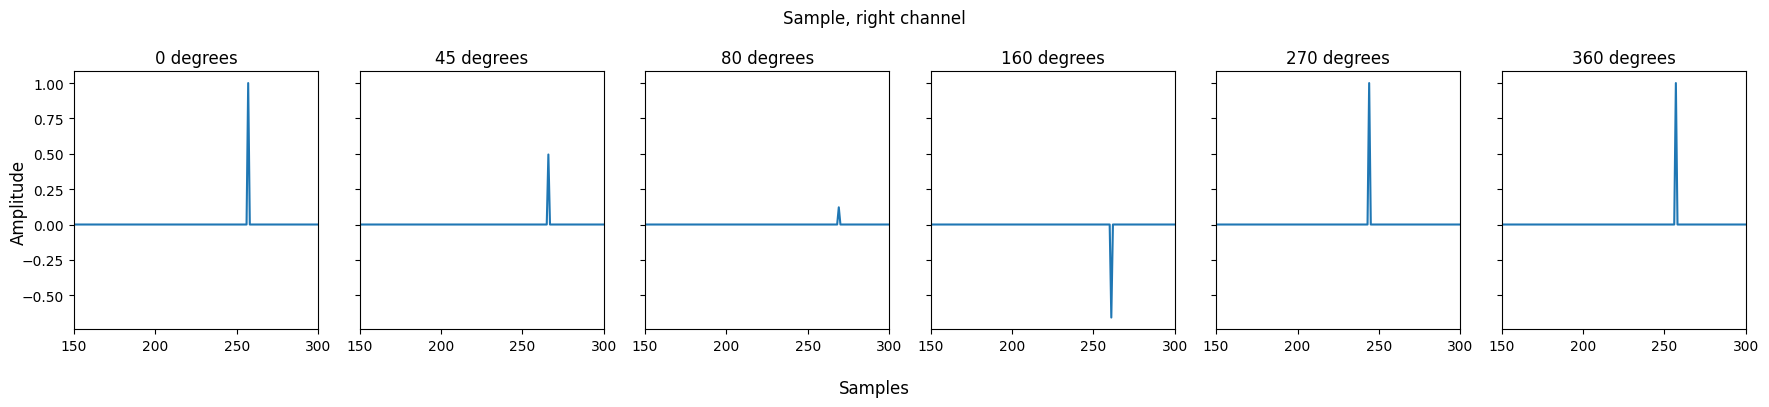

In [38]:
def plot_channels(data, titles, suptitle):
    fig, axes = plt.subplots(1, len(data), sharey=True, figsize=(18, 4))
    fig.suptitle(suptitle)
    fig.supxlabel('Samples')
    fig.supylabel('Amplitude')
    
    for ax, (s, title) in zip(axes, zip(data, titles)):
        ax.plot(s)
        ax.set_title(title)
        ax.set_xlim(150, 300)
    
    plt.tight_layout()
    plt.show()

results = []
for angle, label in zip(angles, labels):
    result, left, right = apply_itd_ild(sample, sample, angle, sr)
    results.append((result, left, right))
    sound(result, sr, label=f"Sample, {label}")

# Plot results
plot_channels([r[1] for r in results], labels, 'Sample, left channel')
plot_channels([r[2] for r in results], labels, 'Sample, right channel')

## 2. Static sources in 3D space using HRTF

While ITD and ILD provide basic spatial cues, Head-Related Transfer Functions (HRTFs) offer a more accurate and immersive 3D audio experience. HRTFs capture how our head and ears filter sound based on its direction. HRTF transforms are performed by loading in a pre-computed filter of angled in 3D space by (azimuth, zenith) and convolving your sound with it.

In [10]:
def load_hrtf( ad, ed):
    """Return the HRTFs for a given azimuth and elevation (zenith)

    Args:
        ad (int): angle in degrees
        ed (int): elevation in degrees

    Returns:
        (np.ndarray, np.ndarray): left and right ear HRTFs
    """
    # Path where the HRTFs are
    p = './hrtf'
    # Get nearest available elevation
    e = max( -40, min( 90, 10*(ed//10)))
    # Get nearest available azimuth
    ad = np.remainder(ad, 360)
    if ad > 180:
        ad = ad-360
    if ad < 0:
        a = abs( ad)
        fl = 1
    else:
        a = ad
        fl = 0
    a = max( 0, min( 180, 5*(a//5)))
    # Load appropriate response
    h = np.fromfile( '%s/elev%d/H%de%.3da.dat' % (p, e, e, a), dtype='>i2').astype( 'double')/32768
    if fl:
        return h[1::2],h[::2]
    else:
        return h[::2],h[1::2]


def convolve_hrtf(sample, ad, ed):
    """Convolves a sample with the right and left HRTF, given some azimuth and elevation (zenith).

    Args:
        sample (np.ndarray): sample array
        ad (int): azimuth angle (the xy-plane)
        ed (int): elevation angle (the xz-plane)

    Returns:
        np.ndarray: the convolved sample
    """
    hrtf_l, hrtf_r = load_hrtf(ad, ed)
    sample_l = convolve(sample, hrtf_r)
    sample_r = convolve(sample, hrtf_l)
    return np.vstack((sample_l, sample_r)), hrtf_l, hrtf_r 

In [13]:
results = []
for angle, label in zip(angles, labels):
    result, left, right = convolve_hrtf(sample, angle, 0)
    results.append((result, left, right))
    sound(result, sr, label=f"Sample, {label}")

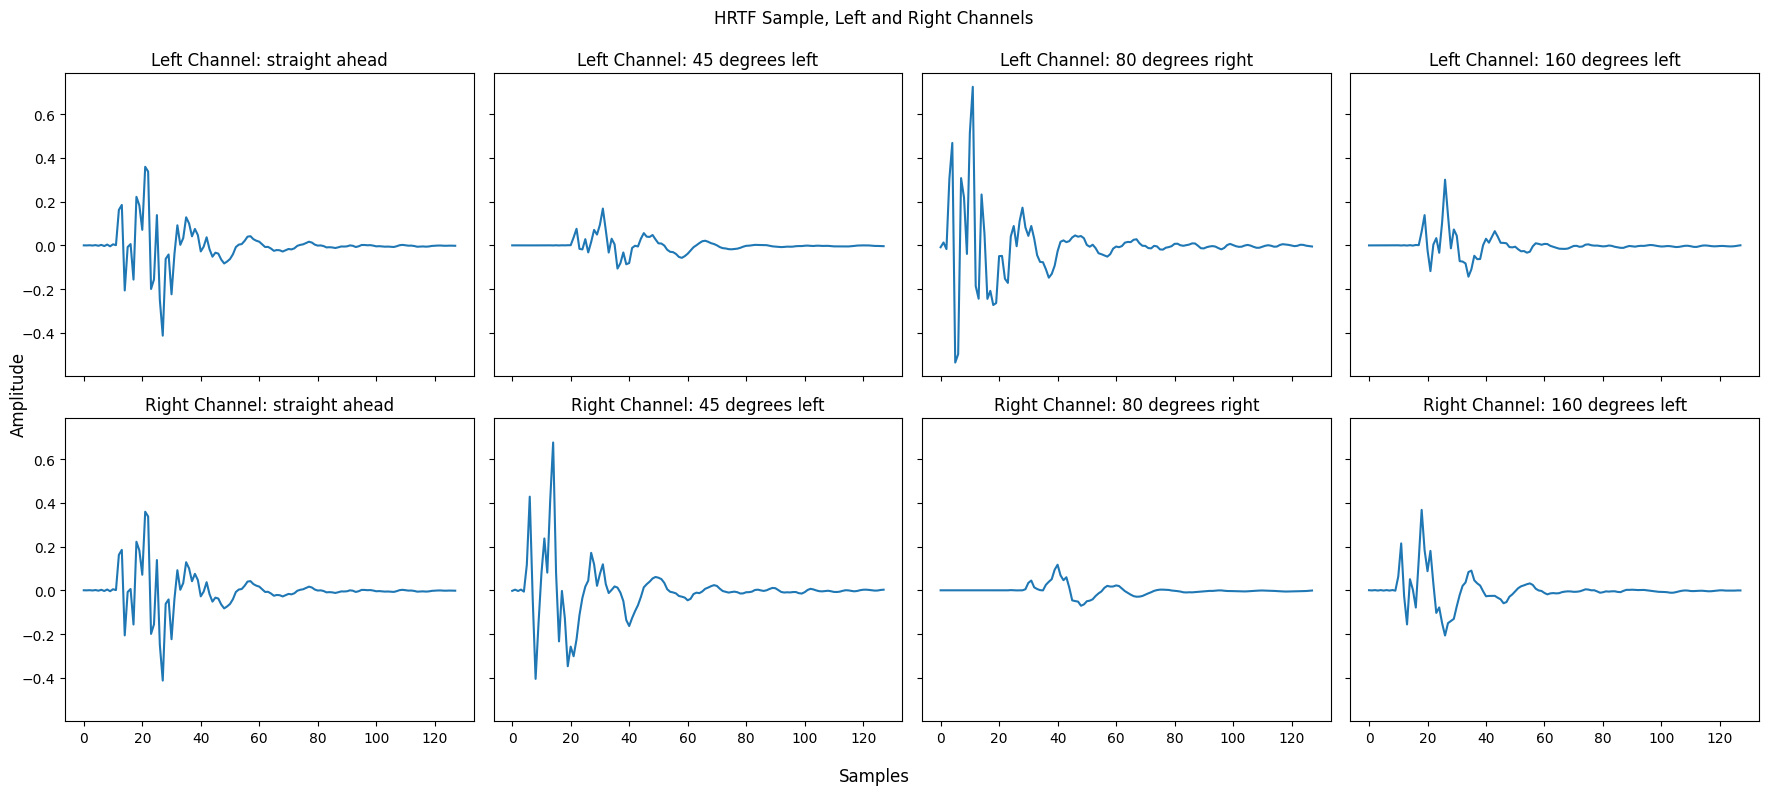

In [47]:
fig, (ax_left, ax_right) = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(18, 8)
fig.suptitle('HRTF Sample, Left and Right Channels')
fig.supxlabel('Samples')
fig.supylabel('Amplitude')

# Plotting the left and right channels using the 'results' array
for i, ((_, left, right), label) in enumerate(zip(results, labels)):
    # Plot left channel
    ax_left[i].plot(left)
    ax_left[i].set_title(f"Left Channel: {label}")

    # Plot right channel
    ax_right[i].plot(right)
    ax_right[i].set_title(f"Right Channel: {label}")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plot
plt.show()

## 3. Dynamic sources in 3D space using HRTF

Now, let's create the illusion of a moving sound source. We'll use the Short-Time Fourier Transform (STFT) to efficiently apply changing HRTFs over time. This creates the illusion of a sound source moving around the listener's head.

In [31]:
def stft( input_sound, dft_size, hop_size, zero_pad):
    frames = []
    
    # zero-padding for equally sized frames
    input_sound = np.append(input_sound, np.zeros(len(input_sound) % dft_size))

    for i in range(0, len(input_sound) - dft_size, hop_size):
        frame = input_sound[i : i + dft_size]
        frames.append(frame)

    spectrogram = np.array([(fft.rfft(f, dft_size + zero_pad)) for f in frames])

    # Return a complex-valued spectrogram (frequencies x time)
    return spectrogram

# ISTFT Function
def istft( stft_output, dft_size, hop_size, zero_pad=0):
    istft_output = np.fft.irfft(stft_output, n=(dft_size + zero_pad))
    frames = len(stft_output) # This line reduces the number of times I type len(x)
    result = np.zeros((frames * hop_size) + dft_size + zero_pad)

    for f in range(0, frames):
        sum = result[f * hop_size : f * hop_size + dft_size + zero_pad]
        sum += istft_output[f]

    # Return reconstructed waveform
    return result


def convolve_hrtf_dynamic(sample, ed, n, cycles=1):
    sample_stft = stft(sample, 512, 256, 0)
    result_l = np.zeros_like(sample_stft, dtype=np.complex64) # left channel's result stored here
    result_r = np.zeros_like(sample_stft, dtype=np.complex64) # right channel's result stored here

    for i in range(len(sample_stft)):
        l, r = load_hrtf(360 * (i / len(sample_stft)) * cycles, ed) # azimuth angle changes with time!
        result_l[i] = sample_stft[i] * fft.rfft(l, n)
        result_r[i] = sample_stft[i] * fft.rfft(r, n)
    temp_l = istft(result_l, 256, 128, 0)
    temp_r = istft(result_r, 256, 128, 0)
    return np.vstack((temp_l, temp_r))

In [32]:
sr, sample = wavread('./data/Bring it Around town.wav')

circling = convolve_hrtf_dynamic(sample, 0, 512, 2)
sound(circling, sr, label="sample, circling around")

/var/folders/1z/vffpnyhj2110bs42k7_mxjsw0000gn/T/ipykernel_78647/4020442038.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, s = read(path)


## Exercises for Practice

1. Create a sound that moves in a figure-eight pattern around the listener.
2. Combine two sound sources and make them move in opposite directions.
3. Experiment with different elevation angles and observe how they affect the perceived height of the sound source.